# Práctica: Análisis de datos para la exploración de pozos con _Python_

## Resumen

El objetivo de este ejercicio es determinar, a través de un análisis de datos, en qué pozos debe de enfocarse la atención para la extracción de petróleo. La metodología adoptada en este documento consiste en analizar la serie de tiempo para cada uno de los pozos con datos para 14 meses. Es decir, sólo se consideran aquellos pozos que cuenten con información para el periodo comprendido entre enero de 2016 y febrero de 2017; dicho rango es el máximo posible de acuerdo con la base de datos  proporcionada.

Para cada uno de los pozos que cumplió con el criterio descrito anteriormente se ajustó una regresión lineal cuya variable dependiente $y$ es la producción de petróleo, y la variable independiente $x$ es el índice del periodo observado. Debido a que se cuenta con 14 meses, el índice de cada periodo es un número entero entre 0 y 13 ( $x \in [0,13]$ ). Cada una de estas regresiones se ajustó para fines meramente descriptivos pues su propósito es obtener una línea de tendencia durante los 14 periodos analizados. Para conocer si la tendencia es positiva o negativa se observó el valor de la pendiente resultante del cómputo de una función lineal a través del método de mínimos cuadrados ordinarios; y para conocer si dicha tendencia, o comportamiento, ha sido estable a lo largo del periodo analizado se observó el coeficiente de determinación $R^2$.

Los pozos seleccionados fueron aquellos cuya línea de tendencia fue positiva y cuya bondad de ajuste es mayor o igual a 0.6; 298 pozos cumplen con esta condición.


## Introducción

Esta práctica se desarrolló con el lenguaje de programación _Python_ y este documento se hizo con una herramienta llamada _Jupyter_. Este trabajo está dividido en tres secciones: procesamiento de datos, metodología, y consideraciones finales.

Los archivos con los cuales se desarrolló este análisis se encuentran almacenados en un repositorio público en _Github_. Éste puede descargarse accediendo a la siguiente liga: https://github.com/danielurencio/pozos.

## 1. Procesamiento de datos

### 1.1 Transformación de formato

Para llevar a cabo este análisis se obtuvo un archivo en formato Excel (xlsx) el cual contiene 138 mil 876 filas y 13 columnas. Antes de cargar la información a una terminal de línea de comando de _Python_ se transformó el archivo original a un formato delimitado por comas (csv). Después, se eliminaron las primeras 8 líneas de dicha transformación y se sustituyeron algunos caracteres.

Se creó, para las tareas que se mencionan, un archivo ejecutable con UNIX Shell, éste contiene 14 líneas. En términos generales, los comandos de este archivo, que se enlistan a continuación, crean y modifican el archivo delimitado por comas (pozos.csv) que será utilizado en _Python_ para llevar a cabo todo el análisis.

In [3]:
# xlsx2csv P*.xlsx > pozos.csv    # Convertir a CSV.
# sed -i '1,8d' pozos.csv         # Eliminar las primeras ocho líneas.
# sed -i "s/  */ /g" pozos.csv    # Borrar dobles espacios.
# sed -i "s/Á/A/g" pozos.csv      # Sustituir caracteres.
# sed -i "s/á/a/g" pozos.csv
# sed -i "s/É/E/g" pozos.csv
# sed -i "s/é/e/g" pozos.csv
# sed -i "s/Í/I/g" pozos.csv
# sed -i "s/í/i/g" pozos.csv
# sed -i "s/Ó/O/g" pozos.csv
# sed -i "s/ó/o/g" pozos.csv
# sed -i "s/Ú/U/g" pozos.csv
# sed -i "s/Ñ/N/g" pozos.csv
# sed -i "s/ñ/n/g" pozos.csv

### 1.2 Dependencias y procesamiento adicional en Python

Las librerías que se utilizaron para este análisis se enlistan a continuación.

In [4]:
%matplotlib inline
from __future__ import division
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from datetime import datetime
from scipy import stats

Una vez que se cuenta con las dependencias es posible cargar el archivo "pozos.csv". Para ello se utilizará la librería _pandas_ y se declarará una variable bajo el nombre de `data` para asignar a ésta la información del archivo delimitado por comas. Asimismo, se cambiará el nombre de todas las columnas para evitar problemas con caracteres latinos (principalmente con palabras acentuadas).

In [5]:
## Crear DataFrame con los datos sobre pozos.
data = pandas.read_csv("pozos.csv",encoding="utf-8",delimiter=",");

## Renombrar columnas.
data.columns = ["periodo","asignacion","region_fiscal","campo_oficial","pozo","ronda_licitacion",
                "compania","produccion_petroleo(mbd)","produccion_gas_asociado(mmpcd)",
                "produccion_gas_no_asociado(mmpcd)","produccion_total_de_gas(mmpcd)","tipo_de_aceite",
                "pozo_productor"];

Ahora que la información del archivo se encuentra en la línea de comando es posible visualizar ésta como una tabla (DataFrame).

In [6]:
data.head()

,periodo,asignacion,region_fiscal,campo_oficial,pozo,ronda_licitacion,compania,produccion_petroleo(mbd),produccion_gas_asociado(mmpcd),produccion_gas_no_asociado(mmpcd),produccion_total_de_gas(mmpcd),tipo_de_aceite,pozo_productor
0,Jan-16,A-0001 - Campo Abkatun,Aguas Someras,Abkatun,ABKATUN-211--,R0,Pemex,0.756978,1.923678,0.0,1.923678,Ligero,1
1,Jan-16,A-0001 - Campo Abkatun,Aguas Someras,Abkatun,ABKATUN-216--,R0,Pemex,0.073139,0.051653,0.0,0.051653,Ligero,1
2,Jan-16,A-0001 - Campo Abkatun,Aguas Someras,Abkatun,ABKATUN-221--,R0,Pemex,0.584042,1.137749,0.0,1.137749,Ligero,1
3,Jan-16,A-0001 - Campo Abkatun,Aguas Someras,Abkatun,ABKATUN-223--,R0,Pemex,0.209442,1.044266,0.0,1.044266,Ligero,1
4,Jan-16,A-0001 - Campo Abkatun,Aguas Someras,Abkatun,ABKATUN-35--,R0,Pemex,1.003177,1.054900,0.0,1.054900,Ligero,1


Para conocer el número de pozos puede hacerse lo siguiente.

In [7]:
## Pozos (sin repetir valores) 
pozos = np.unique(data.pozo.values);
print "Número de pozos:",len(pozos)
print pozos

Número de pozos: 11646
[u'5 PRESIDENTES-12--' u'5 PRESIDENTES-145D-' u'5 PRESIDENTES-151--' ...,
 u'ZAPOTALILLO-3--' u'ZAPOTALILLO-8--' u'ZAPOTALILLO-9--']


Lo anterior indica que existe información para 11 mil 646 pozos.

Dado que este análisis toma en cuenta la serie de tiempo para cada pozo, es necesario asegurarse de que los datos están ordenados con respecto al momento en el que se registró tal observación. Por ello, como medida de precaución, se transformará el formato de los campos que incluyen los periodos (mes y año) a un formato de fechas. Hasta este punto, la información sobre el periodo de tiempo de cada pozo está almacenada como un conjunto de caracteres concatenados, por lo que si se ordenan los datos de modo ascendente se obtendrá un orden alfabético en vez de un orden que refleje la temporalidad en la que las observaciones fueron captadas.

In [8]:
# Ordenar el campo con periodos de modo ascendente.
data.sort_values(by="periodo").head()["periodo"]

36820    Apr-16
35396    Apr-16
35397    Apr-16
35398    Apr-16
35399    Apr-16
Name: periodo, dtype: object

Para corregir lo anterior se cambiará el formato del campo con los periodos, esto tiene el propósito de que, en el código, la información sea interpretada como fechas y no como caracteres.

In [9]:
periodos = data.periodo.values;

# Para cada periodo dar formato de fecha.
for i in range(len(periodos)):
    periodos[i] = periodos[i].encode("utf-8");
    periodos[i] = datetime.strptime(periodos[i],"%b-%y");

# Agregar
periodos = pandas.DataFrame({ "periodos":periodos[:] })
data.periodos = periodos;

# Ordenar por fecha, ahora con el nuevo formato.
data = data.sort_values(by="periodo")
# Mostrar las primeras observaciones.
data.head()["periodo"]


0       2016-01-01 00:00:00
6166    2016-01-01 00:00:00
6167    2016-01-01 00:00:00
6168    2016-01-01 00:00:00
6169    2016-01-01 00:00:00
Name: periodo, dtype: object

Anteriormente, el orden alfabético colocaba en el principio de la tabla a las observaciones del mes de abril de 2016. Después de cambiar el formato las primeras observaciones son de enero de 2016, y las últimas son de febrero de 2017.

In [10]:
periodos = np.unique(data.periodo.values)
print "Número de periodos:",len(periodos)
periodos

Número de periodos: 14


array([datetime.datetime(2016, 1, 1, 0, 0),
       datetime.datetime(2016, 2, 1, 0, 0),
       datetime.datetime(2016, 3, 1, 0, 0),
       datetime.datetime(2016, 4, 1, 0, 0),
       datetime.datetime(2016, 5, 1, 0, 0),
       datetime.datetime(2016, 6, 1, 0, 0),
       datetime.datetime(2016, 7, 1, 0, 0),
       datetime.datetime(2016, 8, 1, 0, 0),
       datetime.datetime(2016, 9, 1, 0, 0),
       datetime.datetime(2016, 10, 1, 0, 0),
       datetime.datetime(2016, 11, 1, 0, 0),
       datetime.datetime(2016, 12, 1, 0, 0),
       datetime.datetime(2017, 1, 1, 0, 0),
       datetime.datetime(2017, 2, 1, 0, 0)], dtype=object)

## 2. Metodología

### 2.1 Selección de observaciones de acuerdo con los periodos disponibles

Se seleccionarán sólo aquellos campos que cuentan con observaciones para el máximo periodo disponible en la base de datos original (son 14 meses de enero de 2016 a febrero de 2017). Para poder conocer qué campos cuentan con observaciones para 14 periodos se declarará una función que, de la tabla original, filtre el número de periodos disponible para cada pozo. Para ello resulta útil la variable llamada `pozos` declarada anteriormente, ésta almacena una lista con los nombres únicos de cada pozo. 

La nueva función que se declarará arroja una nueva tabla con dos columnas. En la primera se encuentran los nombres de cada pozo y en la segunda el número de periodos que existen para cada uno de éstos. La variable `pozos` resulta útil ya que es utilizada por la nueva función para iterar a lo largo de cada una de las observaciones dentro de la tabla original y así obtener el número de periodos que existen.

In [11]:
def NuevaTabla(archivo):
    nuevaTabla = [];
    print "Computando...";
    # Agregar nombre de pozos y periodos disponibles a una lista. La columna '7' es 'produccion_petroleo(mdb)'
    for i in range(len(pozos)):
        nuevaTabla.append( [pozos[i], len( data[data['pozo'] == pozos[i]][[7]] )] );

    # Convertir a formato DataFrame.
    nuevaTabla = np.array(nuevaTabla);
    nuevaTabla = pandas.DataFrame({ 'pozos':nuevaTabla[:,0], 'observaciones':nuevaTabla[:,1] })
    print "Se ha obtenido la nueva tabla..";
    if(archivo):
        # Si la variable 'archivo' es igual a '1' o igual a 'True' crear archivo 'frecuencias.csv'.
        nuevaTabla.to_csv("frecuencias.csv",encoding="utf-8",index=False);
        print "Archivo con frecuencias guardado.";
    return nuevaTabla; # Arrojar nueva tabla.


Como puede notarse, la función anterior puede aceptar un parámetro. En caso de hacerlo, que recomendablemente debe de ser `1` ó `True`, la función creará un archivo delimitado por comas llamado _frecuencias.csv_. Esto es de utilidad ya que la iteración de la función puede tomar mucho tiempo, por lo que si quisiera reanudarse el código sin tener que ejecutar esta función simplemente debe de cargarse el archivo _frecuencias.csv_ usando la librería _pandas_.

In [12]:
# Si no existe el archivo 'frecuencias.csv' y es la primera vez que se ejecuta el script:
# frecuencias = NuevaTabla(1);

# Si ya existe el archivo se puede cargar con pandas:
frecuencias = pandas.read_csv("frecuencias.csv");
frecuencias.head()

,observaciones,pozos
0,14,5 PRESIDENTES-12--
1,6,5 PRESIDENTES-145D-
2,1,5 PRESIDENTES-151--
3,5,5 PRESIDENTES-151D-
4,3,5 PRESIDENTES-160T-


Al contar con el número de observaciones por pozo el siguiente paso es filtrar aquellos pozos que tienen 14 observaciones. La mayoría de los pozos cuenta con observaciones para el máximo periodo posible pues más del 60 por ciento de los registros cumple con esta condición.

In [13]:
# Número inicial de pozos
print "Número total de pozos:",len(frecuencias)

# Aplicar filtro
filtro = frecuencias[frecuencias['observaciones'] == 14]
print "Número de pozos con 14 periodos:",len(filtro)
print "Porcentaje de pozos con 14 periodos:",(len(filtro) / len(frecuencias)) * 100, "%"

Número total de pozos: 11646
Número de pozos con 14 periodos: 7321
Porcentaje de pozos con 14 periodos: 62.8627855058 %


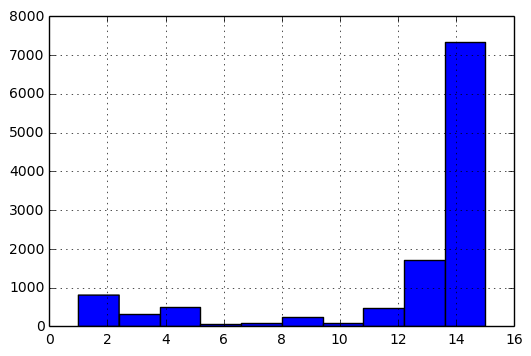

In [14]:
frecuencias["observaciones"].hist()

### 2.2 Parámetros de una regresión lineal simple como medida de tendencia

De manera descriptiva, pueden utilizarse algunos parámetros obtenidos a través del método de mínimos cuadrados ordinarios para establecer medidas de tendencia para una serie de tiempo. Convencionalmente, una regresión lineal, en su forma más simple, está dada por:

$$\hat{y} = \theta_0 + \theta_1 \cdot x$$

En donde $\hat{y}$ es el valor estimado, o variable dependiente, $x$ es la variable independiente, y los parámetros $\theta_0$ y $\theta_1$ representan el intercepto y la pendiente de la función ajustada respectivamente.

Asimismo, el coeficiente de determinación, o $R^2$, es una medida que ofrece información sobre la proporción de la varianza de la variable dependiente que es explicada por la variable independiente; en otras palabras, este coeficiente es una medida para evaluar la bondad del ajuste de una regresión lineal. Este coeficiente, para una ecuación con una sola regresora, puede obtenerse al elevar al cuadrado el coeficiente de correlación de _Pearson_.

$$ \rho^2 = \left( \frac{cov(x,y)}{\sigma_x \cdot \sigma_y} \right) ^2\ = R^2 \in [0,1] $$

Para obtener una medida descriptiva de tendencia para cada una de las series de tiempo de los pozos seleccionados, se estimarán las pendientes y los coeficientes de determinación, $\theta_1$ y $R^2$.

El signo del valor de la pendiente $\theta_1$ será interpretado como un indicador para determinar si la producción de un pozo se ha mantenido constante, si ha crecido, o si ha decrecido. Asimismo, el coeficiente de determinación $R^2$ se utilizará como una medida para conocer si el comportamiento de la tendencia es estable; mientras más cercano a $0$ sea el valor del coeficiente más inestable es la tendencia, y mientras más cercano a $1$ más estable es ésta.

$$ \theta1 < 0 \rightarrow tendencia\ a\ la\ baja $$
$$ \theta1 > 0 \rightarrow tendencia\ a\ la\ alza $$
$$ R^2 \approx 0 \rightarrow tendencia\ inestable $$
$$ R^2 \approx 1 \rightarrow tendencia\ estable $$

### 2.3 Código para la estimación de parámetros

Para hacer estas estimaciones en _Python_ se ha optado por declarar un objeto con métodos. Esto permite estimar los parámetros requeridos con relativamente pocas líneas de código. En otras palabras, para cada pozo se creará una instancia del objeto, de nombre `Reg` (por regresión lineal), y cada instancia podrá ejecutar los métodos que estimarán $\theta_1$ y $R^2$ de la serie de tiempo que corresponden al pozo asignado al objeto. A continuación se presenta el código orientado a objetos y posteriormente se hará una descripción de cómo funcióna éste.

In [15]:
class Reg(object):
    def __init__(self,pozo,variable):
        self.pozo = pozo
        self.variable = variable
        self.x = 0
        self.y = 0
        self.slope = 0
        self.intercept = 0
        self.R_2 = 0
        self.y_yat = 0

    def Parametros(self):
        self.y = data[data['pozo'] == self.pozo][[self.variable]].values;
        self.y = self.y.reshape(1,self.y.shape[0])[0].tolist();
        self.x = [];
        for i in range(len(self.y)):
            self.x.append(i);


        self.x = np.array(self.x);
        self.y = np.array(self.y);
        self.slope,self.intercept,self.R_2,p_value,std_err = stats.linregress(self.x,self.y);
        self.R_2 = self.R_2**2

    def Graficar(self):
        self.y_hat = self.intercept + self.slope * self.x
        plt.plot(self.x,self.y)
        plt.plot(self.x,self.y_hat)
        plt.show()


 El código anterior permite declarar objetos los cuales cuentan con tres métodos, o funciones. El primer método permite recibir los parámetros `pozo` y `variable`, los cuales se refieren al nombre del pozo analizado y a la variable para la cual se estimarán $\theta_1$ y $R^2$ respectivamente; en este análisis sólo se considerará la variable `produccion_petroleo(mbd)`. Tanto $\theta_1$ y $R^2$  se calculan con el segundo método llamado `Parametros`. 
 
 El tercer y último método, `Graficar`, visualiza los datos de la serie de tiempo para el pozo analizado y traza la línea de tendencia obtenida a traves del método de mínimos cuadrados ordinarios; para ello se utiliza la librería _scipy_.
 
Para mayores detalles sobre cómo se calculan $\theta_1$ y $R^2$, considérense los siguientes comentarios para el método `Parametros`.

In [16]:
    def Parametros(self):
        # Se almacenan los datos de la variable seleccionada, para el pozo analizado,
        # y se utilizan como la "y", o variable dependiente, de la regresión.
        self.y = data[data['pozo'] == self.pozo][[self.variable]].values;
        self.y = self.y.reshape(1,self.y.shape[0])[0].tolist();
        # Como variable independiente se utilizan los índices de los periodos existentes.
        # Dado que se toman 14 periodos, el índice para el primer mes sería el 0, para el
        # segundo mes sería el 1, para el tercero el 2, y así sucesivamente hasta llegar al 13.
        self.x = [];
        for i in range(len(self.y)):
            self.x.append(i);


        self.x = np.array(self.x);
        self.y = np.array(self.y);
        # A través de la función "stats.linregress" de la librería 'scipy' pueden obtenerse
        # cinco parámetros de una regresión lineal simple: la pendiente, el intercepto, el
        # coeficiente de Pearson, el 'p value' y el error estándar.
        self.slope,self.intercept,self.R_2,p_value,std_err = stats.linregress(self.x,self.y);
        # Para obtener el coeficiente de determinación, R^2, simplemente se eleva al cuadrado
        # al coeficiente de Person obtenido en la función anterior.
        self.R_2 = self.R_2**2

En resumen, el segundo método toma como variable dependiente al parámetro que se le haya dado al objeto además del nombre del pozo, y como variable independiente se toman los índices de cada uno de los periodos de la serie de tiempo.

$$ \hat{y_i} \equiv variable\ selecionada $$
$$ x_i \equiv i_t \in [0,13] $$

Para esclarecer lo anterior, a continuación se presenta un ejemplo.

Con la variable `pozos`, que almacena el nombre de cada uno de los pozos puede obtenerse el nombre tanto del primero como del último pozo en la lista.



In [17]:
print "Primer pozo de la lista:",pozos[0]
print "Último pozo de la lista:",pozos[len(pozos)-1]

Primer pozo de la lista: 5 PRESIDENTES-12--
Último pozo de la lista: ZAPOTALILLO-9--


Para obtener los parámetros, se declararán instancias del objeto `Reg` para los dos pozos anteriores.

In [18]:
# La variable seleccionada es 'produccion_petroleo(mbd)', cuyo índice de columna es el número 7.
print "El índice 7 corresponde a la variable:",data.columns[7];
print ""

# Declarar objetos para los pozos 5 Presidentes-12 y Zapotalillo-9.
presidentes_12 = Reg(pozos[0],7);
zapotalillo_9 = Reg(pozos[len(pozos)-1],7);

# Estimación de parámetros a través del segundo metodo.
presidentes_12.Parametros();
zapotalillo_9.Parametros();

print "Pendiente y coeficiente de determinación de 5 Presidentes-12:"
print presidentes_12.slope,",",presidentes_12.R_2
print ""
print "Pendiente y coeficiente de determinación de Zapotalillo-9:"
print zapotalillo_9.slope,",",zapotalillo_9.R_2


El índice 7 corresponde a la variable: produccion_petroleo(mbd)

Pendiente y coeficiente de determinación de 5 Presidentes-12:
-0.00460927324165 , 0.703997016224

Pendiente y coeficiente de determinación de Zapotalillo-9:
-0.000218826490386 , 0.416178740363


Para visualizar lo anterior, puede utilizarse el tercer método del objeto `Reg`. Por ejemplo, la gráfica para 5 Presidentes-12 es:

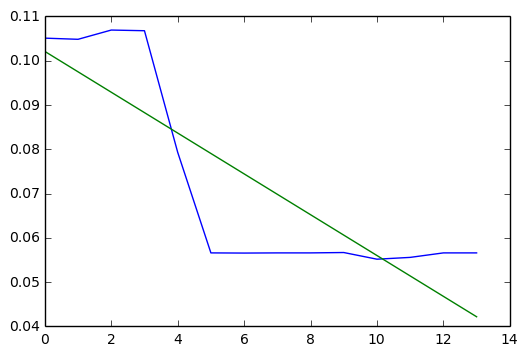

In [19]:
presidentes_12.Graficar()

Y la gráfica para Zapotalillo-9 es:

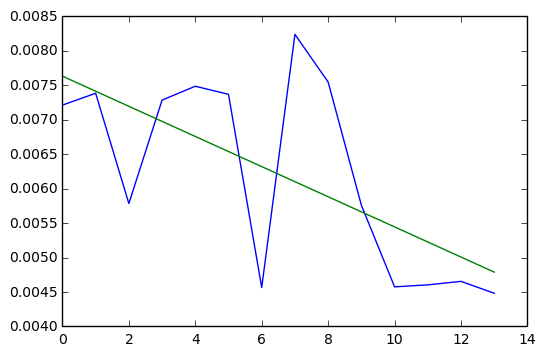

In [20]:
zapotalillo_9.Graficar()

Así como se calcularon los parámetros para los dos pozos anteriores, lo mismo puede hacerse para la totalidad de los pozos dentro de la variable `pozos`. Sin embargo, dado que existen 11 mil 646 pozos, escribir una línea para declarar una instancia del objeto `Reg` para cada uno de los pozos generaría un código sumamente extenso.

Por la razón anterior, se declarará una función que, con menos de 15 líneas, estimará $\theta_1$ y $R^2$ para todos los pozos. Del mismo modo, la función arrojará una tabla con tres columnas; en una se alamacenan los nombres de los pozos, y en las otras dos los parámetros $\theta_1$ y $R^2$ que corresponden a ese mismo pozo. Si se desea, la función también puede aceptar un parámetro, `1` ó `True`, para exportar la tabla generada a un archivo delimitado por comas llamado `params.csv`.

In [21]:
def estimar_parametros(pozos,archivo):
    tabla = []
    for i in range(len(pozos)):
        a = Reg(pozos[i],7)
        a.Parametros();
        b = [pozos[i], a.slope, a.R_2]
        tabla.append(b)
        print pozos[i],a.slope,a.R_2

    tabla = np.array(tabla);
    tabla = pandas.DataFrame({ 'pozos':tabla[:,0],'slopes':tabla[:,1],'R2':tabla[:,2] })
    if(archivo):
        tabla.to_csv("params.csv",encoding="utf-8",index=False);
        print "Archivo con parámetros guardado.";
    return tabla;


In [22]:
# Si es la primera vez que se corre el código y no se cuenta con el archivo 'params.csv':
# params = estimar_parametros(pozos,1);

# Si el archivo 'params.csv' existe:
params = pandas.read_csv("params.csv")

# Los primeros 5 registros de la tabla creada:
params.head()

,R2,pozos,slopes
0,0.703997,5 PRESIDENTES-12--,-0.004609
1,0.860456,5 PRESIDENTES-165--,-0.005293
2,0.040195,5 PRESIDENTES-170--,-0.000010
3,0.193084,5 PRESIDENTES-2--,-0.002759
4,0.063292,5 PRESIDENTES-28--,0.001912


### 2.4 Selección de pozos en función al valor de los parámetros

Dado que el objetivo principal de esta práctica es seleccionar pozos de acuerdo con algún criterio, las condiciones elegidas para determinar en cuáles pozos se deben de enfocar esfuerzos son las siguientes:

* Contar con una pendiente, $\theta_1$, positiva para la regresión simple de la variable escogida
* Contar con un coeficiente de determinación, $R^2$, mayor o igual a 0.6.

En otras palabras, el critero de selección de pozos consiste en observar aquéllos con una producción que muestre una tendencia positiva y moderadamente estable. En el código los filtros pueden aplicarse de la siguiente manera:

array([[<matplotlib.axes.AxesSubplot object at 0x7f2d22d7c3d0>,
        <matplotlib.axes.AxesSubplot object at 0x7f2d22d11150>]], dtype=object)

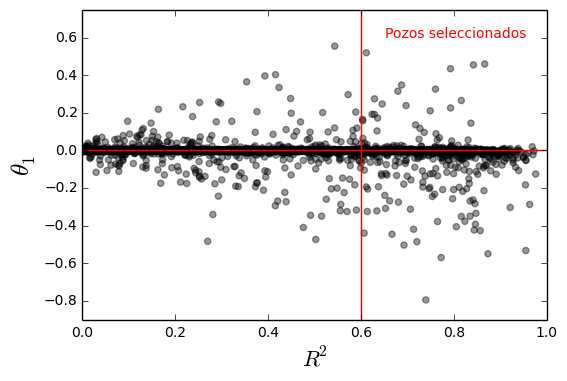

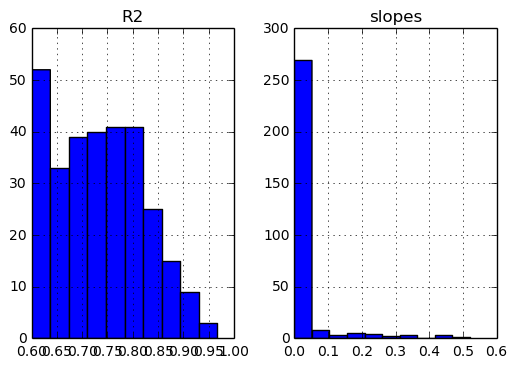

In [24]:
# Aquellos pozos que tengan una R^2 mayor o igual a 0.6 y que tengan una pendiente positiva.
seleccion = params[(params['R2']>=0.6) & (params['slopes']>0)];

#params.hist()
#plt.rcParams['xtick.labelsize'] = 6
#seleccion.hist()
plt.scatter(params['R2'],params['slopes'],color='k',alpha=0.4)

plt.plot((0, 1), (0, 0), 'r')
plt.plot((.6, .6), (-1, 1), 'r')
plt.xlim(0,1)
plt.ylim(-.9,.75)
plt.annotate("Pozos seleccionados",xy=(.65,.6),xytext=(.65,.6),color='red')
plt.ylabel('$\\theta_1$', fontsize=18)
plt.xlabel('$R^2$', fontsize=16)

seleccion.hist()

In [25]:
print "Número de pozos seleccionados:",len(seleccion)

Número de pozos seleccionados: 298


A continuación se muestran algunos de los resultados ordenados, en orden descendiente, primero de acuerdo por el valor de su pendiente y después por el valor de su coeficiente de determinación.

In [27]:
seleccion = seleccion.sort_values(['slopes','R2'], ascending=[0, 0])
seleccion

,R2,pozos,slopes
7274,0.610944,ZAAP-2--,0.520009
7235,0.865349,XANAB-52--,0.460291
7267,0.841306,ZAAP-126--,0.455553
7263,0.791921,ZAAP-110D-,0.435273
3997,0.686679,KU-87--,0.348323
7309,0.759676,ZAAP-95--,0.326552
7287,0.678641,ZAAP-27--,0.315527
7268,0.628424,ZAAP-128--,0.274942
7303,0.815166,ZAAP-48--,0.265930
4166,0.644997,MALOOB-467--,0.247382


Para visualizar la tendencia del pozo con el valor de $R^2$ más elevado puede hacerse lo siguiente.

In [28]:
seleccion.loc[[7274]]

,R2,pozos,slopes
7274,0.610944,ZAAP-2--,0.520009


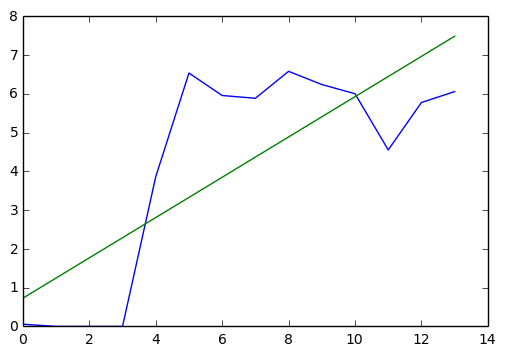

In [29]:
seleccion.loc[[7274]]['pozos']
zaap_2 = Reg("ZAAP-2--",7)
zaap_2.Parametros()
zaap_2.Graficar()

## 3. Consideraciones finales

En esta práctica se optó por generar una solución flexible y escalable que permita modificar los criterios de selección de pozos o aplicar la metodología adoptada a un conjunto de datos más amplio. 

Al usar un lenguaje como _Python_ se puede realizar este mismo análisis para otro conjunto de datos siempre y cuando éste cuente con el mismo formato que tiene la tabla original que se proporcionó para realizar esta práctica. Cuando se dice que esta solución está diseñada para ser escalabe se hace referencia a la posibilidad de reproducir una metodología sin que el _software_ o paquete utilizado se convierta en una restricción; éste puede ser el caso de las hojas de cálculo cuya capacidad para procesar mucha información suele ser limitada.

Al decir que esta solución es flexible se pueden abordar al menos dos aspectos. El primero se refiere a los criterios de selección para los pozos; debido a que se utilizaron filtros para obtener ciertos resultados, basta con cambiar el valor de dichos filtros para obtener resultados diferentes. Por ejemplo, en vez de sólo escoger pozos con 14 observaciones podría relajarse esta condición y tomar en cuenta registros que cuentan con al menos 10 o 12 observaciones; del mismo modo, los valores tanto de $\theta_1$ y de $R^2$ pueden modificarse también.

Otro aspecto que puede ofrecer mucha flexibilidad en el análisis es la programación orientada objetos. En esta práctica sólo se escribieron métodos para calcular algunos parámetros de una regresión lineal; esta metodología puede presentar ciertos problemas pues tanto la pendiente como el coeficiente de determinación usados conjuntamente como medida de tendencia hacen una severa generalización sobre la serie de tiempo observada. No es posible con este método precisar en qué periodo se aceleró o ralentizó la producción de un pozo; asimismo, pueden darse parámetros con valores elevados debido a observaciones atípicas en un periodo tardío que no reflejan el potencial de producción más reciente.

En este sentido, la programación orientada objetos permite escribir nuevos métodos que arrojen nuevos parámetros bajo diferentes metodologías sin tener que modificar grandes porciones del código. Un ejemplo para el tipo de análisis que se hizo en esta práctica es la programación de un método, o función, que calcule las medias móviles simples o exponenciales para las mismas series de tiempo. Las medias móviles ofrecerían una medida de tendencia menos rígida, pues ésta puede variar a lo largo del tiempo en función del comportamiento que muestren los datos; con esto es posible identificar periodos en los que se esté dando un punto de inflexión. Por ejemplo, el cálculo de medias móviles permitiría centrarse en pozos en los que se aprecia una tendencia más pronunciada hacia la alza durante las observaciones más recientes, o descartar a quellos pozos que muestren un comportamiento similar pero a la inversa.


